In [1]:
import chaosode
from scipy.interpolate import CubicSpline
from scipy import integrate
import numpy as np
from matplotlib import pyplot as plt
import utils

### Lorenz Example

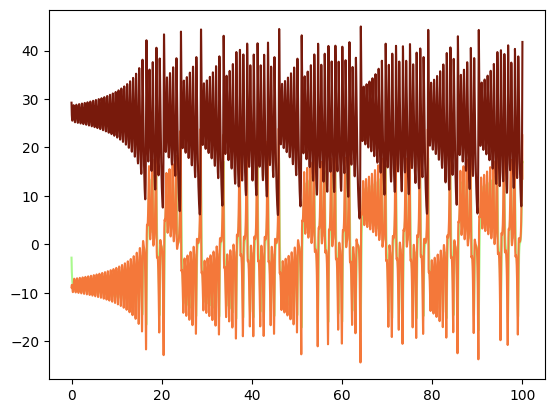

In [2]:
t, U = chaosode.orbit("lorenz", duration=100)
colors = chaosode.plot2d(t, U)

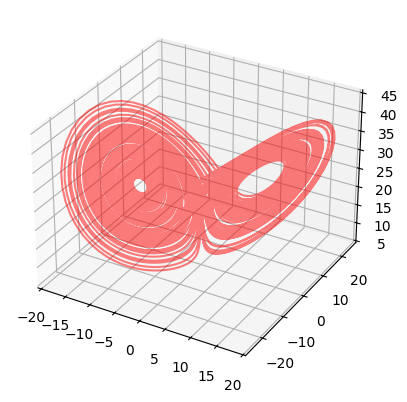

In [4]:
_ = chaosode.plot3d(U, color="red")

### Reservoir Example

In [8]:
# Interpolate data
u = CubicSpline(t, U)
U_train = u(t[:9000])


# Parameters
n = 50
gamma = 5
sigma = 0.14
mean_degree = 1
density = mean_degree / n
alpha = 1e-6

# Directed Erdos-Renyi adjacency matrix
A = (np.random.rand(n, n) < density).astype(float)
# Fixed random matrix
W_in = np.random.rand(n, 3) - .5

# ODE IVP definition and numerical solution
drdt = lambda r, t : gamma * (-r + np.tanh(A @ r + sigma * W_in @ u(t)))
r0 = np.random.rand(n)
states = integrate.odeint(drdt, r0, t[:9000])

# Training step. Project training data onto reservoir states 
W_out =  U_train.T @ states @ np.linalg.inv(states.T @ states )

# Prediction ODE IVP definition and solution
trained_drdt = lambda r, t : gamma * (-r + np.tanh(A @ r + sigma * W_in @ W_out @ r))
r0_pred = states[-1, :]
pred_states = integrate.odeint(trained_drdt, r0_pred, t[9000:])

# Map reservoir states onto the dynamical system space
U_pred = W_out @ pred_states.T

#### Reservoir Internal States

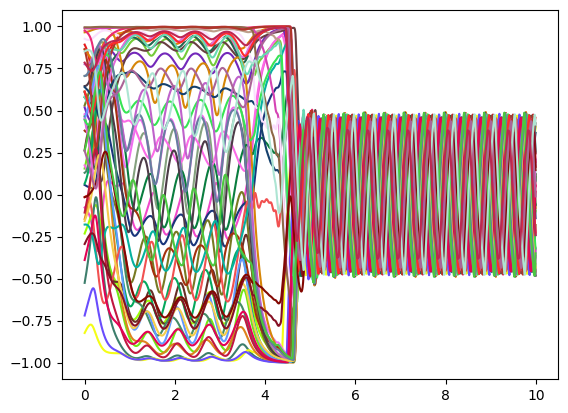

In [10]:
chaosode.plot2d(t[:1000], pred_states[:1000]);
plt.show()

#### Reservoir Prediction

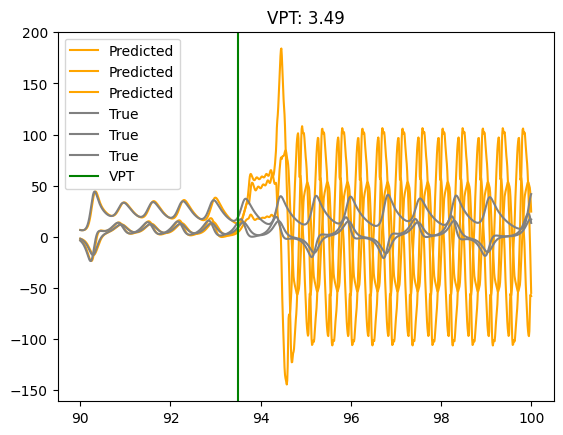

In [31]:
test_t = t[9000:]
# Calculate Valid Prediction Time
vpt = utils.vpt_time(test_t, U_pred.T, u(test_t),vpt_tol=10)

plt.title(f"VPT: {round(vpt,4)}")
plt.plot(test_t, U_pred.T, c="orange", label="Predicted")
plt.plot(test_t, u(test_t), c="gray", label="True")
plt.axvline(x = 90 + vpt, color = 'green', label = 'VPT')
plt.legend()
plt.show()

#### Reservoir Attractor Reconstruction

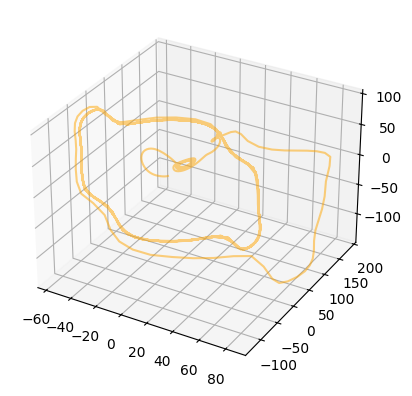

In [12]:
_ = chaosode.plot3d(U_pred.T, color="orange")